In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm

In [ ]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl==1.24.0"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "solc-select"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sk2torch"])
    !solc-select install 0.8.20
    !solc-select use 0.8.20
    !solc --version

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl as damnfair
import sk2torch

Installing solc '0.8.20'...
Version '0.8.20' installed.
Switched global version to 0.8.20
solc, the solidity compiler commandline interface
Version: 0.8.20+commit.a1b79de6.Linux.g++


In [ ]:
folder = "./tmp/"

# Create the directory 'tmp' in the current working directory
try:
    os.makedirs(folder, exist_ok=True)
    print(f"Directory '{folder}' created successfully")
except OSError as error:
    print(f"Directory '{folder}' cannot be created. Error: {error}")

Directory './tmp/' created successfully


## SVC model for CIFAR10


In [ ]:
#from dataset import Dataset
import time
from keras.datasets import cifar10
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader, Subset
from torch.nn.modules.loss import CrossEntropyLoss

import torchvision.datasets as datasets

import sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import hinge_loss

import sk2torch

import copy
from copy import deepcopy
import random
import time

import json
import os
from PIL import Image

import tqdm

In [ ]:
def compare_imgages(img1, img2, size, inv_normalize=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # If an inverse normalization function is provided, apply it
    if inv_normalize:
        img_to_show = inv_normalize(img1.cpu()).permute(1, 2, 0)
    else:
        img_to_show = img1.numpy()

    # Show original image
    axs[0].imshow(img_to_show)  # Transpose back to HxWxC format
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Show normalized grayscale image
    axs[1].imshow(img2.reshape(size,size,1), cmap='gray')
    axs[1].set_title('Grayscale Normalized Image')
    axs[1].axis('off')

    plt.show()

### Data Prep

In [ ]:
# Class Dictionary for CIFAR10
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

binaryClasses = {0:'Machine', 1:'Animal'} # Machine , Animal

data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2470, 0.2435, 0.2616)

In [ ]:
from torch.nn.modules.transformer import TransformerDecoderLayer
# Overwrite getitem method to obtain the index of the images when iterating through the images

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader


class CIFAR10(Dataset):
    def __init__(self, train, transform):
        self.cifar10 = torchvision.datasets.CIFAR10(
                        root='./data', train=train, download=True, transform=transform)
        self.targets = self.cifar10.targets
        self.classes = self.cifar10.classes
        self.data = self.cifar10.data


    # Overloaded the getitem method to return index as well
    def __getitem__(self, index):
        data, target = self.cifar10[index]
        return data, target, index

    # Method to get all images' indices from a certain class without iterating through the loader
    def get_index(self, target_label):
      index_list = []
      for index, label in enumerate(self.targets):
        if label == target_label:
          index_list.append(index)
      return index_list

    def __len__(self):
        return len(self.cifar10)

    def remove(self, remove_list):
      mask = np.ones(len(self.cifar10), dtype=bool)
      mask[remove_list] = False
      data = self.data[mask]

# Data Prep.
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(data_mean, data_std)],
   std= [1/s for s in data_std]
)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])


In [ ]:
trainset = CIFAR10(train=True, transform=transform_train)
testset = CIFAR10(train=False, transform=transform_test)

100%|██████████| 170498071/170498071 [00:10<00:00, 16303700.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np
import torch

def rgb_to_gray(images):
    # Assuming images are (C, H, W) and C=3 for RGB
    return np.dot(images.numpy().transpose((1, 2, 0)), [0.2989, 0.5870, 0.1140])

def process_dataset(dataset, label_map=[2, 3, 4, 5, 6, 7]):
    x_processed = []
    y_processed = []
    img_norms = []
    for index in range(len(dataset)):
        # Retrieve data and target from dataset
        data, target, _ = dataset[index]

        # Convert image to grayscale
        img_grayscale = rgb_to_gray(data)

        # Normalize grayscale image
        norm = np.linalg.norm(img_grayscale, ord=2)
        img_normalized = img_grayscale / norm

        # Store the processed image and label
        x_processed.append(img_normalized.flatten())
        img_norms.append(norm)
        y_processed.append(target in label_map)

    # Convert lists to numpy arrays
    x_processed = np.array(x_processed)
    y_processed = np.array(y_processed, dtype=np.float32)
    img_norms = np.array(img_norms)

    return x_processed, y_processed, img_norms

# Process trainset and testset
x_train, y_train, norms_train = process_dataset(trainset)
x_test, y_test, norms_test = process_dataset(testset)


In [ ]:
# Mannually put indices value
indices = [6143, 1222, 5118, 1137, 9778, 7064, 7584, 1970, 877, 720, 5164, 9853, 5771, 4138, 434, 7594, 4579, 9042, 9818, 6426, 4068, 9532, 2064, 1918, 4825, 1526, 1087, 4131, 5426, 563, 3462, 2847, 930, 5831, 3553, 5589, 1766, 7841, 9831, 4858, 2133, 7795, 2412, 6380, 6046, 2045, 39, 7180, 3485, 9592, 1709, 3532, 6392, 9918, 1605, 2707, 9152, 6632, 5106, 2760, 335, 9637, 1016, 9962, 8376, 4528, 598, 9078, 8917, 4151, 5287, 6516, 5963, 968, 73, 8836, 2396, 9721, 1687, 3872, 2856, 1041, 4224, 2874, 7050, 3467, 7424, 2639, 2164, 4256, 86, 5076, 9107, 871, 6410, 8146, 2509, 4583, 4817, 7547]

In [ ]:
start_time = time.time()

#model_SVC = SVC(kernel = 'linear', max_iter=100, probability=True)
SVC_model = LinearSVC(loss='hinge', max_iter=30000)
#fit
SVC_model.fit(x_train, y_train)

print("Elapsed[s] : ", time.time() - start_time)
print("Train :", SVC_model.score(x_train, y_train))
print("Test :", SVC_model.score(x_test, y_test))

Elapsed[s] :  17.72296118736267
Train : 0.72116
Test : 0.7106


In [ ]:
import torch.nn.functional as F

def compress_image(image, size):
    # Assume image is a PyTorch tensor with shape [C, H, W]

    # Add batch dimension [B, C, H, W] - B is batch size which is 1 in this case
    image = image.unsqueeze(0)

    # Calculate the kernel size, stride and padding needed for average pooling
    kernel_size = (image.size(2) // size, image.size(3) // size)
    stride = kernel_size
    padding = 0

    # Apply average pooling
    compressed_image = F.avg_pool2d(image, kernel_size=kernel_size, stride=stride, padding=padding)

    # Remove batch dimension and return the compressed image
    return compressed_image.squeeze(0)

def compress_process_dataset(dataset, size, label_map = [2,3,4,5,6,7]):
    x = []
    y = []

    for img, label, _ in dataset:
        img = compress_image(img, size)

        # Convert image to grayscale
        img_grayscale = rgb_to_gray(img)

        # Normalize grayscale image by dividing by its Frobenius norm
        norm = np.linalg.norm(img_grayscale, ord=2)
        img_normalized = img_grayscale / norm if norm != 0 else img_grayscale

        # Ensure that all values are within the range [0, 1]
        img_normalized = np.clip(img_normalized, 0, 1)

        x.append(img_normalized.flatten())
        y.append(label in label_map)

    return x,y

In [ ]:
sample_set = Subset(testset, indices)
imgs = []
for img, _, _ in sample_set:
    imgs.append(img)
size = 6
x_test_compress, y_test_compress = compress_process_dataset(sample_set,size)
x_train_compress, y_train_compress = compress_process_dataset(trainset, size)

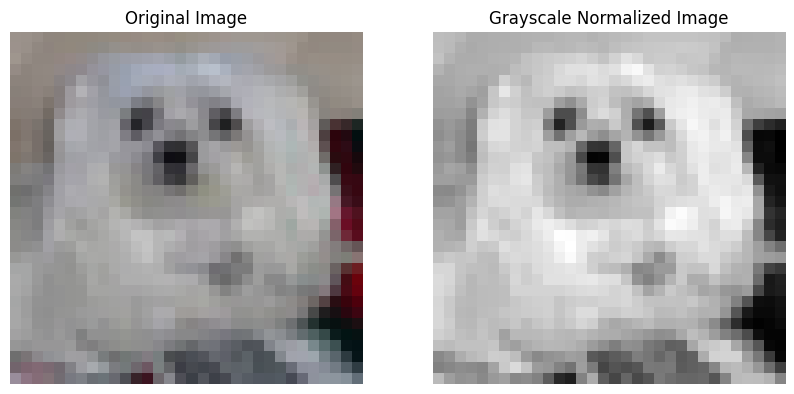

In [ ]:
compare_imgages(imgs[5], x_test[indices[5]],32, inv_normalize)

In [ ]:
start_time = time.time()

#model_SVC = SVC(kernel = 'linear', max_iter=100, probability=True)
SVC_model_comp = LinearSVC(loss='hinge', max_iter=30000)
#fit
SVC_model_comp.fit(x_train_compress, y_train_compress)

print("Elapsed[s] : ", time.time() - start_time)
print("Train :", SVC_model_comp.score(x_train_compress, y_train_compress))
print("Test :", SVC_model_comp.score(x_test_compress, y_test_compress))

Elapsed[s] :  0.5776157379150391
Train : 0.68544
Test : 0.71


In [ ]:
folder = "./tmp"
def gen_SVC_setting(model, imgs, index):
    model_path = os.path.join(folder, 'network.onnx')
    settings_path = os.path.join(folder, 'settings.json')
    data_path = os.path.join(folder, 'input.json')
    cal_data_path = os.path.join(folder, 'cal_data.json')

    grayscale_img = imgs[index]
    grayscale_img = grayscale_img.reshape(1,-1)
    model = sk2torch.wrap(model)
    x = torch.from_numpy(grayscale_img)
    torch_out = model.predict(x)

    # Export the model
    torch.onnx.export(model,                     # model being run
                    x,                         # model input (or a tuple for multiple inputs)
                    model_path,                # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names = ['input'],   # the model's input names
                    output_names = ['output'], # the model's output names
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

    d = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_shapes=[grayscale_img.shape[1:]],
                input_data=[d],
                output_data=[o.reshape([-1]).tolist() for o in torch_out])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    # # use the test set to calibrate the circuit
    cal_data = dict(input_data = imgs)

    # Serialize calibration data into file:
    json.dump(data, open(cal_data_path, 'w'))

    py_run_args = damnfair.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    py_run_args.param_visibility = "private" # private by default

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = damnfair.gen_settings(model_path, settings_path, py_run_args=py_run_args)
    assert res == True

    # with open(settings_path, "r") as file:
    #     setting = json.load(file)

    # # Change input_visibility to Public
    # setting['run_args']['input_visibility'] = 'Public'

    # # Save it back to the file
    # with open(settings_path, 'w') as file:
    #     json.dump(setting, file, indent=4)




def gen_SVC_verifier(prefix):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json')
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')
    proof_path = os.path.join(folder, 'proof.json')

    res = damnfair.compile_model(model_path, compiled_model_path, settings_path)
    assert res == True

    res = damnfair.get_srs(srs_path, settings_path)

    res = damnfair.setup(
            compiled_model_path,
            vk_path,
            pk_path,
            srs_path,
            settings_path,
        )


    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # Generate the Witness for the proof

    # now generate the witness file
    witness_path = os.path.join(folder, 'witness.json')

    res = damnfair.gen_witness(data_path, compiled_model_path, witness_path, settings_path = settings_path)
    assert os.path.isfile(witness_path)

    # Generate the proof

    proof_path = os.path.join('proof.json')

    proof = damnfair.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            srs_path,
            "evm",
            "single",
            settings_path,
        )

    print(proof)
    assert os.path.isfile(proof_path)

    # verify our proof

    res = damnfair.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path,
        )

    assert res == True
    print("verified")

    sol_code_path = os.path.join(prefix + '_SVC_verifier.sol')
    abi_path = os.path.join(folder, 'Verifier.abi')

    res = damnfair.create_evm_verifier(
            vk_path,
            srs_path,
            settings_path,
            sol_code_path,
            abi_path
        )

    assert res == True
    assert os.path.isfile(sol_code_path)

    return proof

In [ ]:
index = 5

In [ ]:
model_path = os.path.join(folder, 'network.onnx')
settings_path = os.path.join(folder, 'settings.json')
data_path = os.path.join(folder, 'input.json')
cal_data_path = os.path.join(folder, 'cal_data.json')

gen_SVC_setting(SVC_model_comp, x_test_compress, index)
# gen_SVC_setting(SVC_model, x_test, index)
res = await damnfair.calibrate_settings(data_path, model_path, settings_path, "resources")  # Optimize for resources
proof = gen_SVC_verifier(str(index))

/usr/local/lib/python3.10/dist-packages/sk2torch/linear_model.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if outputs.shape[1] == 1:


{'instances': [[[6425625360762666998, 7924344314350639699, 14762033076929465436, 2023505479389396574], [6425625360762666998, 7924344314350639699, 14762033076929465436, 2023505479389396574], [415066004289224689, 11886516471525959549, 3696305541684646538, 3035258219084094862], [7959790035488735211, 12951774245394433045, 16242874202584236123, 560012691975822483], [7959790035488735211, 12951774245394433045, 16242874202584236123, 560012691975822483], [6425625360762666998, 7924344314350639699, 14762033076929465436, 2023505479389396574], [0, 0, 0, 0], [7959790035488735211, 12951774245394433045, 16242874202584236123, 560012691975822483], [0, 0, 0, 0], [12436184717236109307, 3962172157175319849, 7381016538464732718, 1011752739694698287], [1949230679015292902, 16913946402569752895, 5177146667339417225, 1571765431670520771], [6425625360762666998, 7924344314350639699, 14762033076929465436, 2023505479389396574], [0, 0, 0, 0], [7959790035488735211, 12951774245394433045, 16242874202584236123, 5600126

In [ ]:
onchain_input_array = []
for value in proof["instances"]:
    for field_element in value:
        onchain_input_array.append(damnfair.vecu64_to_int(field_element))
print ("Input:", onchain_input_array)
with open(str(index)+'.json', 'w') as file:
   json.dump({'instances': onchain_input_array, 'proof': '0x' + proof['proof']}, file)

print ("Proof:", '0x' + proof['proof'])

Input: [2, 2, 3, 4, 4, 2, 0, 4, 0, 1, 5, 2, 0, 4, 0, 0, 5, 2, 2, 4, 4, 4, 5, 4, 3, 4, 5, 3, 2, 0, 3, 2, 2, 0, 0, 0, 1]
Proof: 0x0e4673750f8ed1d9a66fd5c1f98014b1bbb1b08f1c76a2fc1f380afd94b309b11484b7690a69df0ed668619300566f363298ef9b37dcbefaab2af1c2a287505518d52631039e83a2c5ce81b82f340f5c89a81d7489f3105747722841a2aaa479182c7aa3b51a8ac1ee84a7676999a4d2357041adc48589f3e4d527710a56db7c2c284eff707b029f4e6f4113bd848ca3057a5eab11c502220eabead29db97ae8179095401d12a31d77c37eaa0f473a20e85e9961d3d53cd92718878db29b090f1803dfadcd9fc2865ffab5f176d8b1d6cd296b0a5388ed6d286d4ae8cf747a9a1856d7546e4cec525f6086d052b000d2cdfbadc53f2d79f3a4b51e5a0d67c45222bfd2938fdf846ce478bc58a3541724f6822488e51eb3eb499d3d4c61a8ad3201ec010e10737dac823fad89aaae71f45ea0ddfd45154255722d389ec6314c33102f03bef15deb2873241cf9536bda348d1d5750dbbbce2112e30edb8cdb6dce16baa374088aca266a50166254b088120c2cebd883700ce627e73554c7b36ab82fca129a1a33438a4f17be6d65bf3c07b6196def8cfc36636c13f2a67d609e191e39e1089218a20da3e8f2c58611ce693f1ae451